#Kaggle Advanced SQL

In [ ]:
import pandas as pd
from google.cloud import bigquery

##Using Bigquery with Cloud API

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
project_id = 'sqlkaggleadvanced'
client = bigquery.Client(project=project_id)

#1) Types of **JOIN**

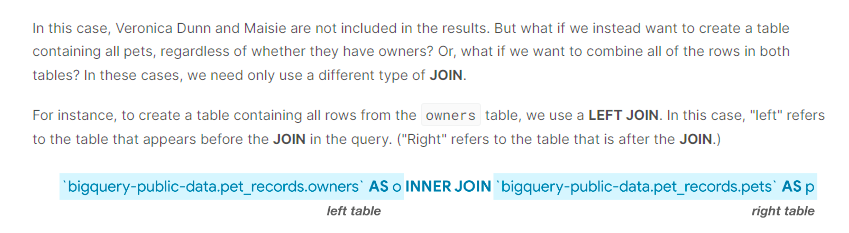

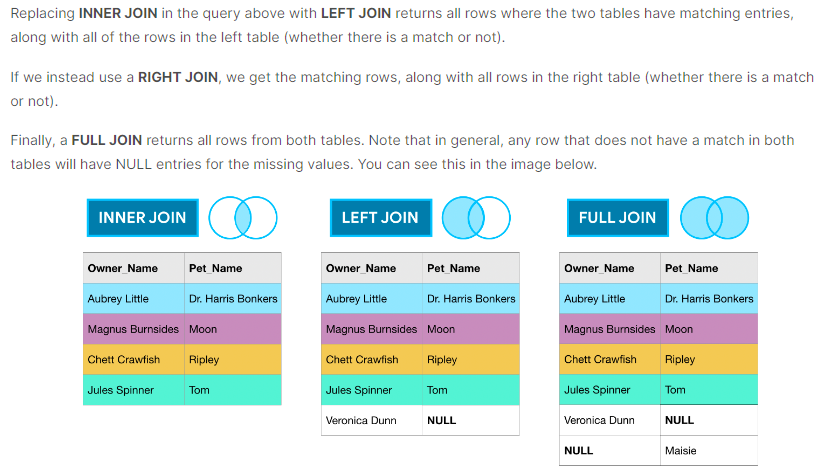

**Exemplo 01:**

In [ ]:
# Construct a reference to the "hacker_news" dataset (dataset publico do google cloud: https://cloud.google.com/bigquery/public-data and go to market place)
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "full" table
table_ref = dataset_ref.table('comments')

# API request - fetch the table
table = client.get_table(table_ref)

In [ ]:
# Preview the first five lines of the table COMMENTS
client.list_rows(table, max_results=5).to_dataframe()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,2701393,5l,5l,1309184881,2011-06-27 14:28:01+00:00,And the glazier who fixed all the broken windo...,2701243,None,None,0
1,5811403,99,99,1370234048,2013-06-03 04:34:08+00:00,Does canada have the equivalent of H1B/Green c...,5804452,None,None,0
2,21623,AF,AF,1178992400,2007-05-12 17:53:20+00:00,"Speaking of Rails, there are other options in ...",21611,None,None,0
3,10159727,EA,EA,1441206574,2015-09-02 15:09:34+00:00,Humans and large livestock (and maybe even pet...,10159396,None,None,0
4,2988424,Iv,Iv,1315853580,2011-09-12 18:53:00+00:00,I must say I reacted in the same way when I re...,2988179,None,None,0


In [ ]:
# Construct a reference to the STORIES table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,id,by,score,time,time_ts,title,url,text,deleted,dead,descendants,author
0,6940813,sarath237,0,1387536270,2013-12-20 10:44:30+00:00,Sheryl Brindo Hot Pics,http://www.youtube.com/watch?v=ym1cyxneB0Y,Sheryl Brindo Hot Pics,None,True,NaN,sarath237
1,6991401,123123321321,0,1388508751,2013-12-31 16:52:31+00:00,Are you people also put off by the culture of ...,,They&#x27;re pretty explicitly &#x27;startup f...,None,True,NaN,123123321321
2,1531556,ssn,0,1279617234,2010-07-20 09:13:54+00:00,New UI for Google Image Search,http://googlesystem.blogspot.com/2010/07/googl...,Again following on Bing's lead.,None,None,0.0,ssn
3,5012398,hoju,0,1357387877,2013-01-05 12:11:17+00:00,Historic website screenshots,http://webscraping.com/blog/Generate-website-s...,Python script to generate historic screenshots...,None,None,0.0,hoju
4,7214182,kogir,0,1401561740,2014-05-31 18:42:20+00:00,Placeholder,,Mind the gap.,None,None,0.0,kogir


**The query below pulls information from the *STORIES* and *COMMENTS* tables to create a table showing all stories posted on January 1, 2012, along with the corresponding number of comments. We use a LEFT JOIN so that the results include stories that didn't receive any comments.** 

In [ ]:
# O c selecionou a coluna 'parent' e a contou (quantas vezes apareceu) e a chamou de 'num_comments'
# Posteriormente, selecionou as colunas ID (igual a coluna parent da comments), by, title e a num_comments.
# Left join da c com a s, já que s.id = c.parent. Depois utilizou um WHERE EXTRACT para indicar a data exata que queria

join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
)

             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

In [ ]:
# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

,story_id,by,title,num_comments
0,3412900,whoishiring,Ask HN: Who is Hiring? (January 2012),154.0
1,3412901,whoishiring,Ask HN: Freelancer? Seeking freelancer? (Janua...,97.0
2,3412643,jemeshsu,Avoid Apress,30.0
3,3414012,ramanujam,Impress.js - a Prezi like implementation using...,27.0
4,3412891,Brajeshwar,"There's no shame in code that is simply ""good ...",27.0


In [ ]:
#Veio valores 'NaN' em num_comments por que foi LEFT JOIN da 'c', ou seja, TUDO da 'c' veio para o join, mesmo que nao tenha conexão com a outra tabela.
join_result.tail()

,story_id,by,title,num_comments
439,3413256,microcon,Newcastle vs Man Utd Live Stream 4 January 2012,NaN
440,3413234,aksharajanu,URDU SEX STORIES: Doodh Or Kelaa,NaN
441,3413477,craquesdefutebo,Reino Unido - Pelos caminhos do rei Artur,NaN
442,3413065,web4ukm,"Rumah u/ Kantor/Usaha , Dekat Pintu Tol Padala...",NaN
443,3413951,weemee,Criminal Justice Petition: Demand justice for ...,NaN


#2)Analytic Functions
No microcurso Intro to SQL, você aprendeu a usar funções de agregação, que realizam cálculos com base em conjuntos de linhas. Neste tutorial, você aprenderá a definir funções analíticas, que também operam em um conjunto de linhas. No entanto, ao contrário das funções agregadas, as funções analíticas retornam um valor (potencialmente diferente) para cada linha na tabela original.

As funções analíticas nos permitem realizar cálculos complexos com uma sintaxe relativamente direta. Por exemplo, podemos calcular rapidamente médias móveis e totais em execução, entre outras quantidades.

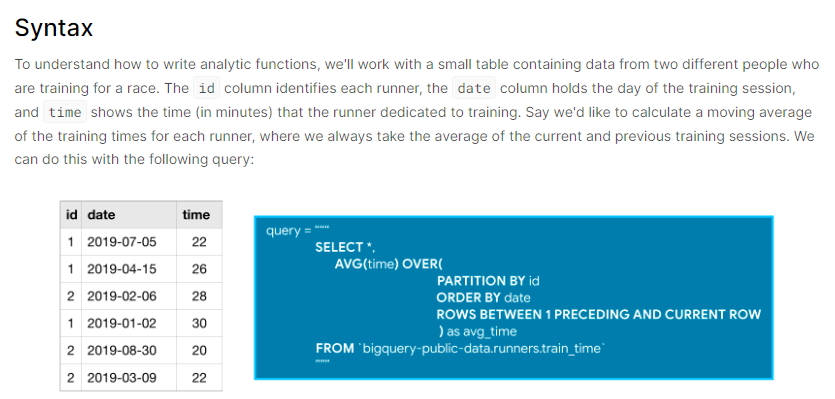

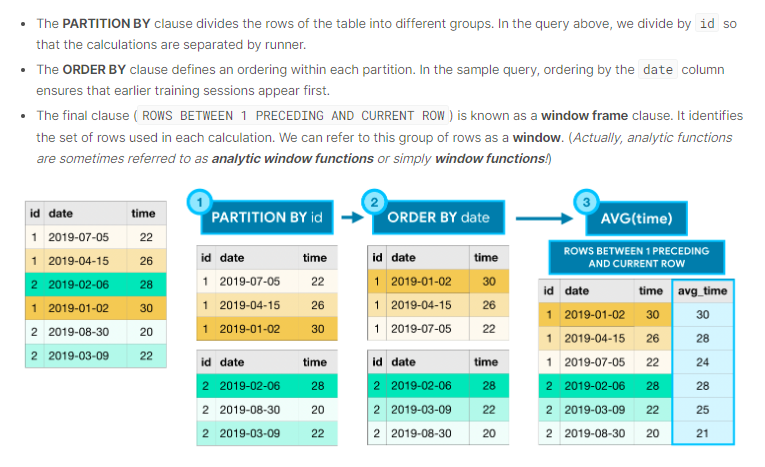

**Exemplificando**, existem diversas maneiras de escrever uma window frame:
1. ROWS BETWEEN 1 PRECEDING AND CURRENT ROW -> A linha anterior e a linha atual
2. ROWS BETWEEN 3 PRECEDING AND CURRENT ROW -> As últimas 3 linhas, a linha atual e a próxima linha
3. ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING -> Todas as linhas na partição
4. ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING

**Funções analiticas de agregação**:
Min() or Max()
AVG()
SUM()
COUNT()

**Funções de navegação:**
FIRST_VALUE() or LAST_VALUE(): Retorna o primeiro ou último valor do input
LEAD() e LAG(): Retorna o valor de uma linha subsequente ou precedente

 

**Exemplo 01:** 
Número de corridas por dia, em 2015? Analisando o dataset da cidade de são francisco e as corridas de bicicleta

In [ ]:
# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


In [ ]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """


In [ ]:
# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

,trip_date,num_trips,cumulative_trips
0,2015-01-01,181,181
1,2015-01-02,428,609
2,2015-01-03,283,892
3,2015-01-04,206,1098
4,2015-01-05,1186,2284


**Exercício 01:** 1) How can you predict the demand for taxis?
Digamos que você trabalhe para uma empresa de táxi e esteja interessado em prever a demanda por táxis. Para atingir esse objetivo, você gostaria de criar um gráfico que mostrasse uma média móvel do número diário de viagens de táxi. Altere a consulta (parcial) abaixo para retornar um DataFrame com duas colunas:

- trip_date - contém uma entrada para cada data de 1º de janeiro de 2016 a 31 de dezembro de 2017.
- avg_num_trips - mostra o número médio de viagens diárias, calculado em uma janela incluindo o valor da data atual, juntamente com os valores dos 15 dias anteriores e dos 15 dias seguintes, desde que os dias caibam no período de dois anos . 

Por exemplo, ao calcular o valor nesta coluna para 5 de janeiro de 2016, a janela incluirá o número de viagens dos 4 dias anteriores, a data atual e os 15 dias seguintes.

Essa consulta está parcialmente concluída para você e você precisa apenas escrever a parte que calcula a coluna avg_num_trips. Observe que essa consulta usa uma expressão de tabela comum (CTE);

In [ ]:
#Data set -> Chicago taxi trips

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "taxi_trips" table
table_ref = dataset_ref.table("taxi_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,a87e452ec8561990a676bc7b5e3fd56dde07132d,164ca43b6cd736df744b37d9f537022f147be159ab5150...,2014-01-09 19:00:00+00:00,2014-01-09 19:00:00+00:00,NaN,0.0,None,None,None,None,...,0.0,17.34,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
1,720faf38f916384b9760f041b130c648735f3cc2,7d21c2ca227db8f27dda96612bfe5520ab408fa9a462c8...,2014-08-20 14:45:00+00:00,2014-08-20 14:45:00+00:00,0.0,0.0,None,None,None,None,...,0.0,17.05,Credit Card,T.A.S. - Payment Only,None,None,None,None,None,None
2,70c2b1e85f90b4893255420a1c3dcd1dcdc78832,2da7a72559676f28d81edf5e68011b5a16c548ade88599...,2014-01-19 16:45:00+00:00,2014-01-19 17:00:00+00:00,960.0,0.0,None,None,None,None,...,0.0,21.06,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
3,31975179cf28ba1f127510a9b41af2ec4d539f43,2966e1dc6860fdd9b956fffd45dc8df03487ece230e63d...,2014-01-21 13:45:00+00:00,2014-01-21 14:15:00+00:00,1980.0,0.0,None,None,None,None,...,0.0,45.66,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
4,1cbf9e085db453aa3d05de8d00088dcbe1e7c576,75a6a6b4e014d27ba8e94667fb0c2feb9f17227df8305c...,2014-01-19 15:00:00+00:00,2014-01-19 15:00:00+00:00,0.0,0.0,None,None,None,None,...,0.0,15.00,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


In [ ]:
avg_num_trips_query = """
                      WITH trips_by_day AS
                      (
                      SELECT DATE(trip_start_timestamp) AS trip_date,
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      WHERE trip_start_timestamp >= '2016-01-01' AND trip_start_timestamp < '2018-01-01'
                      GROUP BY trip_date
                      ORDER BY trip_date
                      )
                      SELECT trip_date,
                          AVG(num_trips)
                          OVER (
                                ORDER BY trip_date
                                ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING                        
                               ) AS avg_num_trips
                      FROM trips_by_day
                      """

In [ ]:
# Run the query, and return a pandas DataFrame
num_taxitrips_result = client.query(avg_num_trips_query).result().to_dataframe()
num_taxitrips_result.head()

,trip_date,avg_num_trips
0,2016-01-01,80461.937500
1,2016-01-02,80150.647059
2,2016-01-03,79419.611111
3,2016-01-04,79810.421053
4,2016-01-05,80293.900000


#3)Nested and Repeated Data:
Aprenda a query em tipos de dados complexos em bigquery

**Nós podemos dizer que determinada coluna permite 'repeated data', pois permite mais de um valor em cada linha. Uma coluna com repeated data, iria aparecer da seguinte maneira na tabela schema:**

SchemaField('Toys', 'STRING', **'REPEATED'**, None, () )

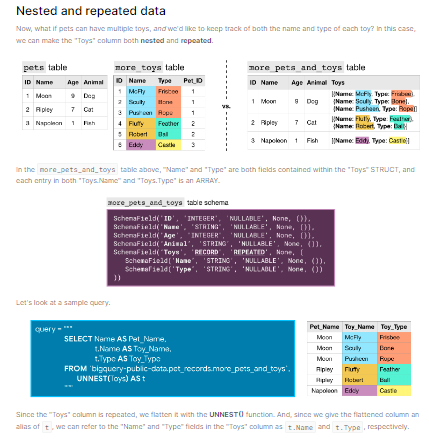

In [ ]:
# Exemplo 01: Google Analytics dataset -> Informação do comportamento dos visitantes no google merchandise store (e-commerce)

# Construct a reference to the "google_analytics_sample" dataset
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")

# Construct a reference to the "ga_sessions_20170801" table
table_ref = dataset_ref.table("ga_sessions_20170801")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()



,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,None,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,None,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,None,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,None,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


**Esse exemplo possui muitos nested fields (ao plotar as tabelas SCHEMAS, análise os tipo 'RECORDS' = nested fields), como a coluna , 'Totals', 'Device', e 'Hits'**
Para análise podemos fazer a seguinte query para contar o número de transações por browser:
O campo **browser** (nested in the 'device' column) e o campo **transactions** (nested inside the 'totals' column) como device.browser e totals.transactions na query abaixo:
1. device.browser (pega a info browser da coluna device)
2. totals.transactions (pega a info transactions da coluna totals) 

In [ ]:
# Query to count the number of transactions per browser 
query_browser = """
        SELECT device.browser AS device_browser,
            SUM(totals.transactions) as total_transactions
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
        GROUP BY device_browser
        ORDER BY total_transactions DESC
        """


In [ ]:
# Run the query, and return a pandas DataFrame
browser_result = client.query(query_browser).result().to_dataframe()
browser_result.head()

,device_browser,total_transactions
0,Chrome,41.0
1,Safari,3.0
2,Firefox,1.0
3,Internet Explorer,NaN
4,UC Browser,NaN


**Acima, utilizando a estrutura dita evitamos muitos JOINS e seus possíveis problemas. Agora abaixo iremos aprender como utilizar a coluna 'hits' que apresenta dados nested and repeated:**
  1. 'hits' é como um dicionário, contêm nested data and repeated.
  2. 'hitNumber', 'page' e 'type' estão nested inside 'hit' columnd
  3. 'pagePath' nested inside 'page' field

In [ ]:
# Query to determine most popular landing point on the website
# Importante: UNNEST (hits) fez separar os nested data em itens individuais, a partir dai foi possível criar a análise

query_hits = """
        SELECT hits.page.pagePath as path,
            COUNT(hits.page.pagePath) as counts
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`, 
            UNNEST(hits) as hits
        WHERE hits.type="PAGE" and hits.hitNumber=1
        GROUP BY path
        ORDER BY counts DESC
        """

In [ ]:
# Run the query, and return a pandas DataFrame
hits_result = client.query(query_hits).result().to_dataframe()
hits_result.head()

,path,counts
0,/home,1257
1,/google+redesign/shop+by+brand/youtube,587
2,/google+redesign/apparel/mens/mens+t+shirts,117
3,/signin.html,78
4,/basket.html,35


#4) Writing Efficiente Queries

**Para utilização de queries em datasets grandes, as vezes é necessário utilizar artificios conhecidos como **query optimizer**. Por exemplo, em consultas que serão executadas muitas vezes, como uma consulta que alimenta um site com dados? Eles precisam ser eficientes para que você não deixe os usuários esperando o carregamento do seu site.

Algumas funções podem ser utilizadas com o objetivo de comparar as perfomances / eficiência de diferentes queries:
  1. show_amount_of_data_scanned() 
  2. show_time_to_run()

In [ ]:
 from time import time

 def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

### Estratégias para melhorar a perfomance:
  **1**. Selecione apenas colunas que queira trabalhar:
    Pode ser bastante ineficiente selecionar todas as colunas como SELECT * FROM, isso é especialmente importante quando tem textos nos campos que você não precisa. 
    Abaixo, perceba que selecionando colunas o processamento utiliza 1000x menos dados scaneados para completar a query. 



In [ ]:
star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(basic_query)

Data processed: 2660.567 GB
Data processed: 2.515 GB


**2.** Ler menos dados
As duas queries abaixo calculam a média de duração em segundos de uma viagem de bicicleta em São francisco:

"Since there is a 1:1 relationship between the station ID and the station name, we don't need to use the start_station_id and end_station_id columns in the query. By using only the columns with the station IDs, we scan less data." 

In [ ]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(less_data_query)

Data processed: 0.076 GB
Data processed: 0.06 GB


**3.** Evitar N:JOIN, ou seja, sempre priorizar utilizar querys que façam apenas um JOIN na mesma query, o exemplo abaixo retorna o mesmo resultado, mas com tempos de execução diferente, veja só:

In [ ]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(small_join_query)

Time to run: 16.032 seconds
Time to run: 3.882 seconds


**The first query has a large N:N JOIN. By rewriting the query to decrease the size of the JOIN, we see it runs much faster.**

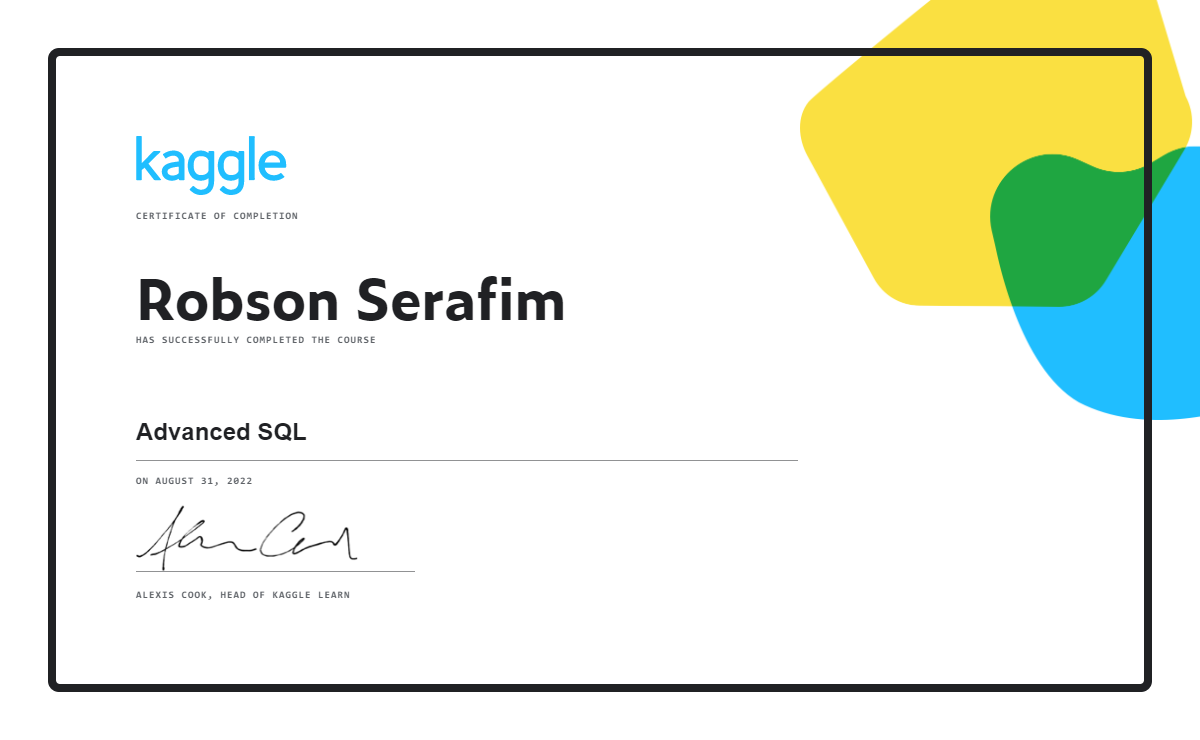